In [37]:
import pandas as pd
from math import *
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection
Train=pd.read_csv('Data/TrainData4.csv')
Input=pd.read_csv('Data/WeatherForecastInput4.csv')
Train.head()

,TIMESTAMP,POWER,U10,V10,U100,V100
0,20150101 00:00,NaN,NaN,NaN,NaN,NaN
1,20150101 01:00,NaN,6.24102,3.49613,9.73707,4.78492
2,20150101 02:00,NaN,5.62234,4.06239,8.94497,5.71768
3,20150101 03:00,0.666693,5.99531,4.89334,9.52143,6.99094
4,20150101 04:00,NaN,6.90809,4.79099,10.63280,6.75417


In [38]:
Train=Train.dropna()
Train= Train.reset_index(drop=True)
Train.head()

,TIMESTAMP,POWER,U10,V10,U100,V100
0,20150101 03:00,0.666693,5.99531,4.89334,9.52143,6.99094
1,20150101 06:00,0.937501,6.17865,5.70277,9.73491,8.09731
2,20150101 09:00,0.935002,7.39201,5.66010,11.21580,8.10729
3,20150101 12:00,0.912940,7.83819,5.51678,12.56750,8.25853
4,20150101 15:00,0.971080,7.37616,7.39868,11.32480,10.65240


In [39]:
#Remove outlier 
#from scipy import stats
#Z=stats.zscore(Train[['U10','V10','U100','V100']])
#Index=np.where(np.abs(Z) > 3)[0]
#Train=Train.drop(Train.index[Index]).reset_index()



In [40]:
Train['WS10']=[sqrt(Train['U10'][i]**2+Train['V10'][i]**2) for i in range(len(Train['U10']))]
Train['WS100']=[sqrt(Train['U100'][i]**2+Train['V100'][i]**2) for i in range(len(Train['U100']))]
Train['WS']=[np.interp(70, [10,100], [Train['WS10'][i],Train['WS100'][i]]) for i in range(len(Train['WS10']))]
Train['WS1']=[pow((70/100),(0.14))*Train['WS100'][i] for i in range(len(Train['WS100']))]

Training model of type:

Sequential(
  (0): Linear(in_features=5, out_features=15, bias=True)
  (1): Tanh()
  (2): Linear(in_features=15, out_features=1, bias=True)
  (3): Sigmoid()
)


Crossvalidation fold: 1/3

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.017514927	9.719094e-05
		2000	0.016678175	2.791962e-05
		3000	0.016305625	1.9876197e-05
		4000	0.016037302	1.2891878e-05
		5000	0.015870372	8.3329305e-06
		Final loss:
		5336	0.015828872	8.23718e-07

	Best loss: 0.015828872099518776


Crossvalidation fold: 2/3

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.017024156	0.00013499605
		2000	0.016377376	2.2177408e-05
		3000	0.0160356	1.8468601e-05
		4000	0.015769288	3.437131e-05
		5000	0.015558414	9.876759e-06
		Final loss:
		5687	0.0154783465	7.220321e-07

	Best loss: 0.01547834649682045


Crossvalidation fold: 3/3

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.017162679	9.961952e-05
		2000	0.01632957	2.2812636e-05
		3000	0.016021388	1.6624892e-05
		4000	0.015798328	1.07289125

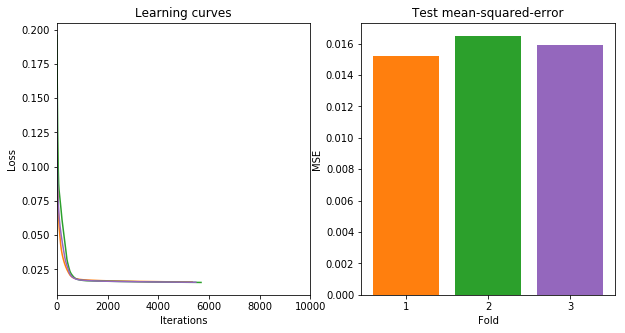

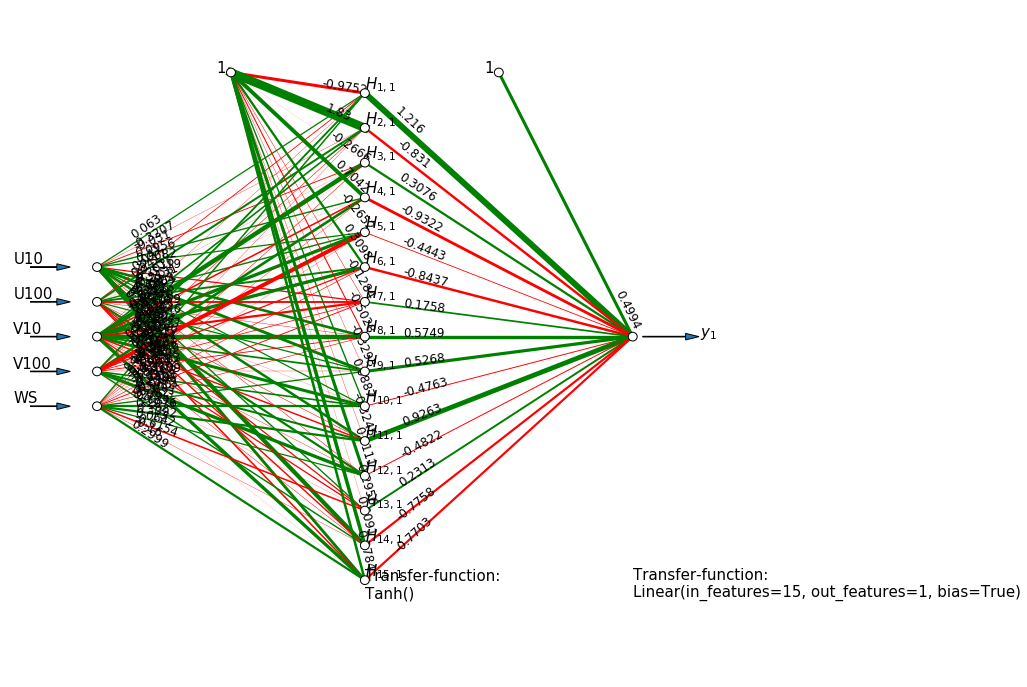


Estimated generalization error, RMSE: 0.12600000202655792


<Figure size 432x288 with 0 Axes>

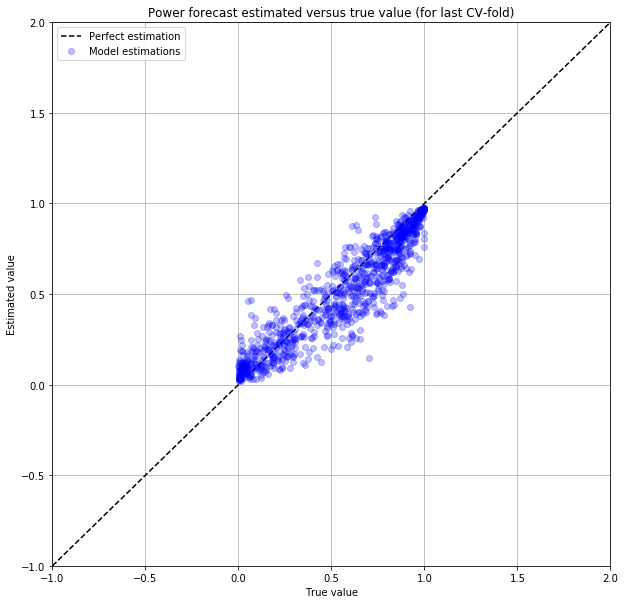

In [42]:
from toolbox import train_neural_net, draw_neural_net
from scipy import stats
import torch
X = Train[['U10','U100','V10','V100','WS','POWER']]
          
X=np.array(X)
attributeNames=['U10','U100','V10','V100','WS']

y=X[:,[5]] 
X=X[:,0:5]
N, M = X.shape
#C = 2


                
## Normalize and compute PCA (change to True to experiment with PCA preprocessing)
do_pca_preprocessing = False
if do_pca_preprocessing:
    Y = stats.zscore(X,0);
    U,S,V = np.linalg.svd(Y,full_matrices=False)
    V = V.T
    #Components to be included as features
    k_pca = 3
    X = X @ V[:,0:k_pca]
    N, M = X.shape


# Parameters for neural network classifier
n_hidden_units = 15      # number of hidden units
n_replicates = 1        # number of networks trained in each k-fold
max_iter = 10000        # 

# K-fold crossvalidation
K = 3                   
CV = model_selection.KFold(K, shuffle=True)


summaries, summaries_axes = plt.subplots(1,2, figsize=(10,5))

color_list = ['tab:orange', 'tab:green', 'tab:purple', 'tab:brown', 'tab:pink',
              'tab:gray', 'tab:olive', 'tab:cyan', 'tab:red', 'tab:blue']
# Define the model
model = lambda: torch.nn.Sequential(
                    torch.nn.Linear(M, n_hidden_units), #M features to n_hidden_units
                    torch.nn.Tanh(),   # 1st transfer function,
                    torch.nn.Linear(n_hidden_units, 1),# n_hidden_units to 1 output neuron
                    torch.nn.Sigmoid() #2nd tranfer function
                   
                    )
loss_fn = torch.nn.MSELoss() 

print('Training model of type:\n\n{}\n'.format(str(model())))
errors = [] # make a list for storing generalizaition error in each loop
for (k, (train_index, test_index)) in enumerate(CV.split(X,y)): 
    print('\nCrossvalidation fold: {0}/{1}'.format(k+1,K))    
    
    # Extract training and test set for current CV fold, convert to tensors
    X_train = torch.tensor(X[train_index,:], dtype=torch.float)
    y_train = torch.tensor(y[train_index], dtype=torch.float)
    X_test = torch.tensor(X[test_index,:], dtype=torch.float)
    y_test = torch.tensor(y[test_index], dtype=torch.float)
    
    # Train the net on training data
    net, final_loss, learning_curve = train_neural_net(model,
                                                       loss_fn,
                                                       X=X_train,
                                                       y=y_train,
                                                       n_replicates=n_replicates,
                                                       max_iter=max_iter)
    
    print('\n\tBest loss: {}\n'.format(final_loss))
    
    # Determine estimated class labels for test set
    y_test_est = net(X_test)
    
    # Determine errors and errors
    se = (y_test_est.float()-y_test.float())**2 # squared error
    mse = (sum(se).type(torch.float)/len(y_test)).data.numpy() #mean
    errors.append(mse) # store error rate for current CV fold 
    
    # Display the learning curve for the best net in the current fold
    h, = summaries_axes[0].plot(learning_curve, color=color_list[k])
    h.set_label('CV fold {0}'.format(k+1))
    summaries_axes[0].set_xlabel('Iterations')
    summaries_axes[0].set_xlim((0, max_iter))
    summaries_axes[0].set_ylabel('Loss')
    summaries_axes[0].set_title('Learning curves')

# Display the MSE across folds
summaries_axes[1].bar(np.arange(1, K+1), np.squeeze(np.asarray(errors)), color=color_list)
summaries_axes[1].set_xlabel('Fold');
summaries_axes[1].set_xticks(np.arange(1, K+1))
summaries_axes[1].set_ylabel('MSE');
summaries_axes[1].set_title('Test mean-squared-error')
plt.savefig('Learningcurve.eps',format='eps',dpi=500)    
print('Diagram of best neural net in last fold:')
weights = [net[i].weight.data.numpy().T for i in [0,2]]
biases = [net[i].bias.data.numpy() for i in [0,2]]
tf =  [str(net[i]) for i in [1,2]]
draw_neural_net(weights, biases, tf, attribute_names=attributeNames)
plt.savefig('Neural_network.eps',format='eps',dpi=500)

# Print the average classification error rate
print('\nEstimated generalization error, RMSE: {0}'.format(round(np.sqrt(np.mean(errors)), 4)))


plt.figure(figsize=(10,10));
y_est = y_test_est.data.numpy(); y_true = y_test.data.numpy();
axis_range = [np.min([y_est, y_true])-1,np.max([y_est, y_true])+1]
plt.plot(axis_range,axis_range,'k--')
plt.plot(y_true[0:1000], y_est[0:1000],'ob',alpha=.25)
plt.legend(['Perfect estimation','Model estimations'])
plt.title('Power forecast estimated versus true value (for last CV-fold)')
plt.ylim(axis_range); plt.xlim(axis_range)
plt.xlabel('True value')
plt.ylabel('Estimated value')
plt.grid()
plt.savefig('NN_compare.eps',format='eps',dpi=500)
plt.show()

In [43]:
Input['WS10']=[sqrt(Input['U10'][i]**2+Input['V10'][i]**2) for i in range(len(Input['U10']))]
Input['WS100']=[sqrt(Input['U100'][i]**2+Input['V100'][i]**2) for i in range(len(Input['U100']))]
Input['WS']=[np.interp(70, [10,100], [Input['WS10'][i],Input['WS100'][i]]) for i in range(len(Input['WS10']))]
Input['WS1']=[pow((70/100),(0.14))*Input['WS100'][i] for i in range(len(Input['WS100']))]
X_inp=Input[['U10','U100','V10','V100','WS']]
y_est=net(torch.tensor(np.array(X_inp), dtype=torch.float))
Input['FORECAST']=y_est.data.numpy()
Input[['TIMESTAMP','FORECAST']].to_csv('31761-Nuclearwouldbeeasier-stage4.csv')
